# Installing PySpark



In [ ]:
# @title
# 1. Install Java Development Kit (JDK) 8
# Spark requires a Java environment to run
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2. Install Apache Spark
# We install version 3.5.1 (a recent, stable version)
!pip install pyspark==3.5.1

# 3. Install findspark (makes finding Spark easy)
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 16.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=24914502d78d45ec4726105a76b5cd404bf9985d2133c0e5cefe7276319998f3
  Stored in directory: /root/.cache/pip/wheels/b1/91/5f/283b53010a8016a4ff1c4a1edd99bbe73afacb099645b5471b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9
  Attempting uninstall: pyspark
    Found existing installation: pyspark 4.0.1
    Uninstalling pyspark-4.0.1:
      Successfully uninstalled pyspark-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-conn

# Installling vaderSentiment for sentiment analysis

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


# Florin


In [ ]:
# @title
import gzip
import shutil

# URL of the gzipped file
url = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_books.json.gz"
output_gz_file = "goodreads_books.json.gz"
output_json_file = "goodreads_books.json"

# Download the file using wget
!wget -O {output_gz_file} {url}

# Decompress the file
with gzip.open(output_gz_file, 'rb') as f_in:
    with open(output_json_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Downloaded and decompressed {output_gz_file} to {output_json_file}")

--2026-01-08 10:16:01--  https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_books.json.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2083197934 (1.9G) [application/gzip]
Saving to: ‘goodreads_books.json.gz’

goodreads_books.jso 100%[===================>]   1.94G  49.9MB/s    in 40s     

2026-01-08 10:16:41 (49.5 MB/s) - ‘goodreads_books.json.gz’ saved [2083197934/2083197934]

Downloaded and decompressed goodreads_books.json.gz to goodreads_books.json


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, trim, initcap, when, regexp_replace,
    sha2, concat_ws, row_number, lit, array, size, transform
)
from pyspark.sql.window import Window

spark = SparkSession.builder \
    .appName("CleanBooksMetadata") \
    .config("spark.sql.parquet.compression.codec", "snappy") \
    .getOrCreate()

HDFS_INPUT_PATH = "goodreads_books.json"
HDFS_OUTPUT_PATH = "goodreads_books_clean"

print("Loading books metadata from HDFS...")
books_df = spark.read.json(HDFS_INPUT_PATH)

print(f"Initial record count: {books_df.count()}")
books_df.printSchema()

# Data Cleaning Steps

# 1. Handle missing ISBNs - generate synthetic ISBN
print("Handling missing ISBNs...")
books_df = books_df.withColumn(
    "isbn",
    when(col("isbn").isNull() | (trim(col("isbn")) == ""),
         sha2(concat_ws("_", col("book_id"), col("title")), 256).substr(1, 10))
    .otherwise(trim(col("isbn")))
)

books_df = books_df.withColumn(
    "isbn13",
    when(col("isbn13").isNull() | (trim(col("isbn13")) == ""),
         sha2(concat_ws("_", col("book_id"), col("title"), lit("13")), 256).substr(1, 13))
    .otherwise(trim(col("isbn13")))
)

print("Fixing name formatting...")

books_df = books_df.withColumn(
    "authors_list",
    when(col("authors").isNull() | (size(col("authors")) == 0), array(lit("Unknown Author")))
    .otherwise(transform(col("authors"), lambda x: x.author_id))
)

books_df = books_df.withColumn(
    "authors_clean",
    when(col("authors_list").isNull(), lit("Unknown Author"))
    .otherwise(concat_ws(", ", col("authors_list")))
)

books_df = books_df.withColumn(
    "authors_clean",
    when(col("authors_clean") == "", lit("Unknown Author"))
    .otherwise(trim(regexp_replace(col("authors_clean"), "\\s+", " ")))
)

books_df = books_df.withColumn(
    "title",
    when(col("title").isNull() | (trim(col("title")) == ""), lit("Unknown Title"))
    .otherwise(trim(col("title")))
)

books_df = books_df.withColumn(
    "title",
    regexp_replace(col("title"), "\\s+", " ")
)

print("Removing duplicates...")

# Persist before expensive operations to avoid recomputation
books_df = books_df.persist()

initial_count = books_df.count()
books_df = books_df.dropDuplicates(["title"])
final_count = books_df.count()
print(f"Removed {initial_count - final_count} duplicate records")

# Simpler deduplication by ISBN - just keep first occurrence
books_df = books_df.dropDuplicates(["isbn"])

# Display final statistics
final_count = books_df.count()
print(f"Final record count: {final_count}")

print(f"Saving cleaned data to {HDFS_OUTPUT_PATH}...")
books_df.write \
    .mode("overwrite") \
    .parquet(HDFS_OUTPUT_PATH)

# Unpersist to free memory
books_df.unpersist()

print("Books metadata cleaning completed successfully!")

# Optional: Display sample of cleaned data
print("\nSample of cleaned data:")
spark.read.parquet(HDFS_OUTPUT_PATH).select("book_id", "isbn", "isbn13", "authors_clean", "title").show(20, truncate=False)

# Stop Spark session (Removed as it caused a race condition with write operation)
# spark.stop()

No active Spark session to stop or failed to stop.
Loading books metadata from HDFS...
Initial record count: 2360655
root
 |-- asin: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- edition_information: string (nullable = true)
 |-- format: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- is_ebook: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: string (nullable = true)
 |-- kindle_asin: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- link: string (nullable = true)
 |-- num_pages: string (nullable = true)
 |-- popular_shelves: array (nullable = true)
 |    |-- element: struct (conta

Task #2

Loading cleaned books data...

1. PUBLISHER DOMINANCE ANALYSIS

Top 40 Publishers by Number of Publications:
+-------------------------------------------+-----------------+
|publisher_name                             |publication_count|
+-------------------------------------------+-----------------+
|Createspace Independent Publishing Platform|14622            |
|Smashwords Edition                         |8653             |
|Harlequin                                  |7557             |
|Createspace                                |7336             |
|Oxford University Press, USA               |5496             |
|HarperCollins                              |4265             |
|Marvel                                     |4183             |
|Amazon Digital Services                    |4082             |
|Mondadori                                  |3870             |
|Penguin Books                              |3728             |
|Gramedia Pustaka Utama                     |3643          

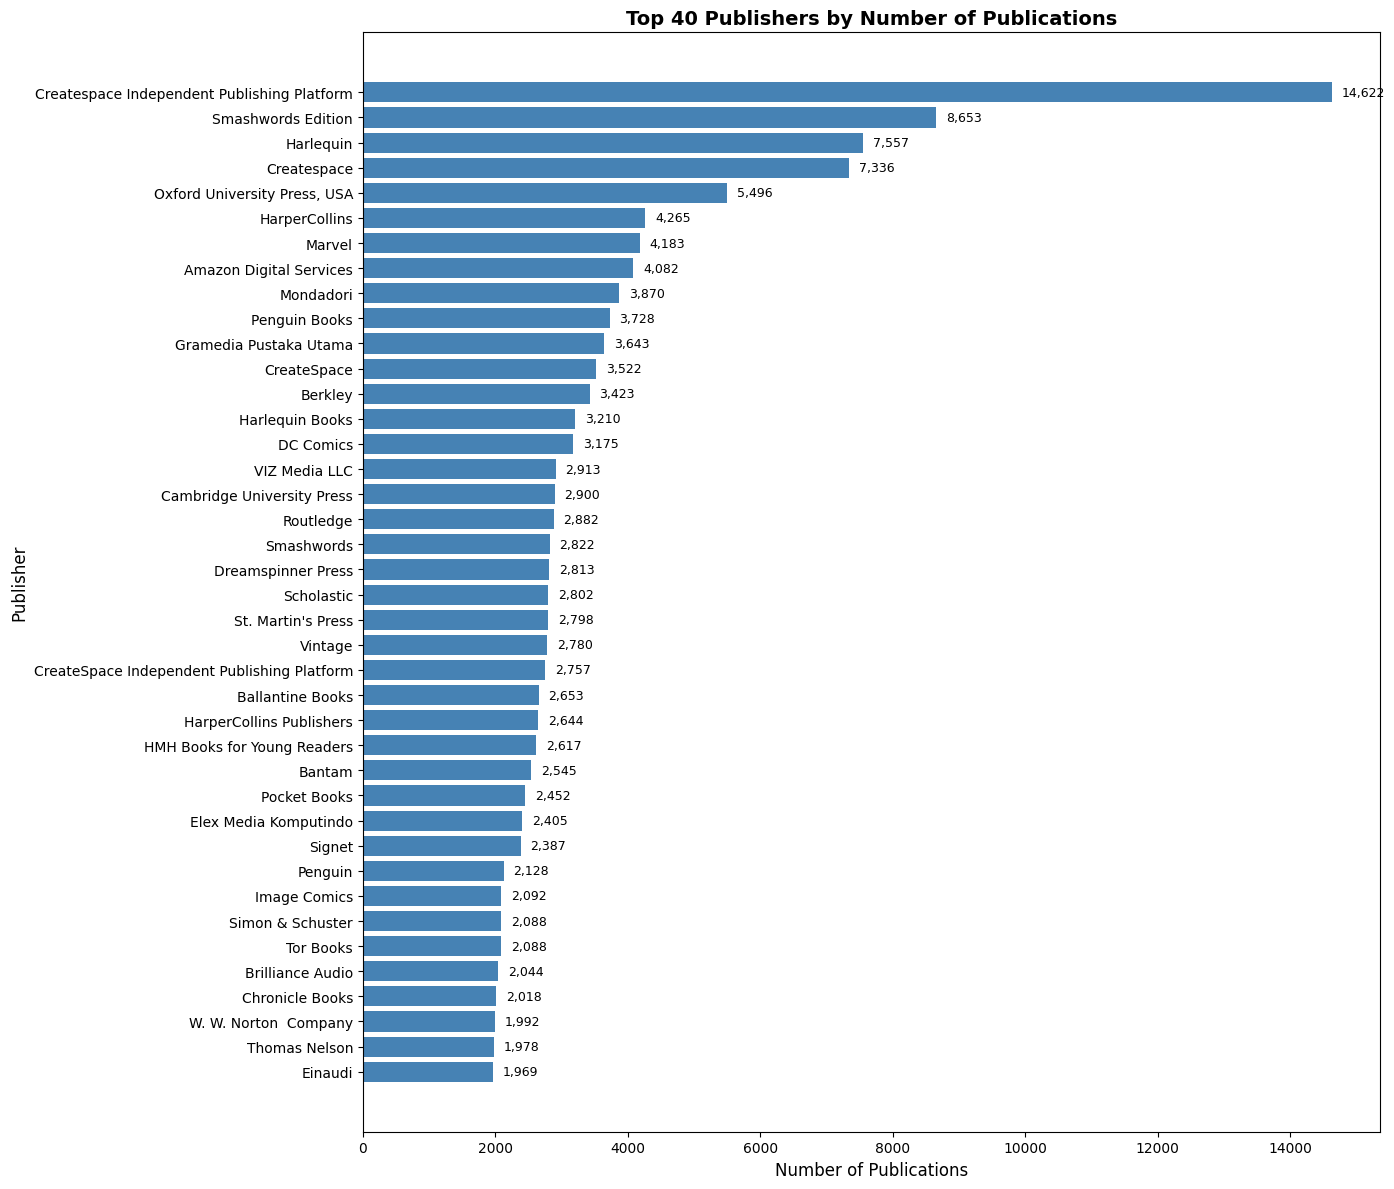

Chart saved as 'publisher_dominance.png'

2. PUBLICATIONS BY TIME RANGES (DECADES)

Publications by Time Range:
+-----------+-----------------+
|time_range |publication_count|
+-----------+-----------------+
|Before 1900|2874             |
|1900-1949  |6372             |
|1950s      |5513             |
|1960s      |12615            |
|1970s      |22973            |
|1980s      |45691            |
|1990s      |116319           |
|2000s      |346751           |
|2010s      |745769           |
|2020s      |433              |
|Unknown    |460664           |
+-----------+-----------------+



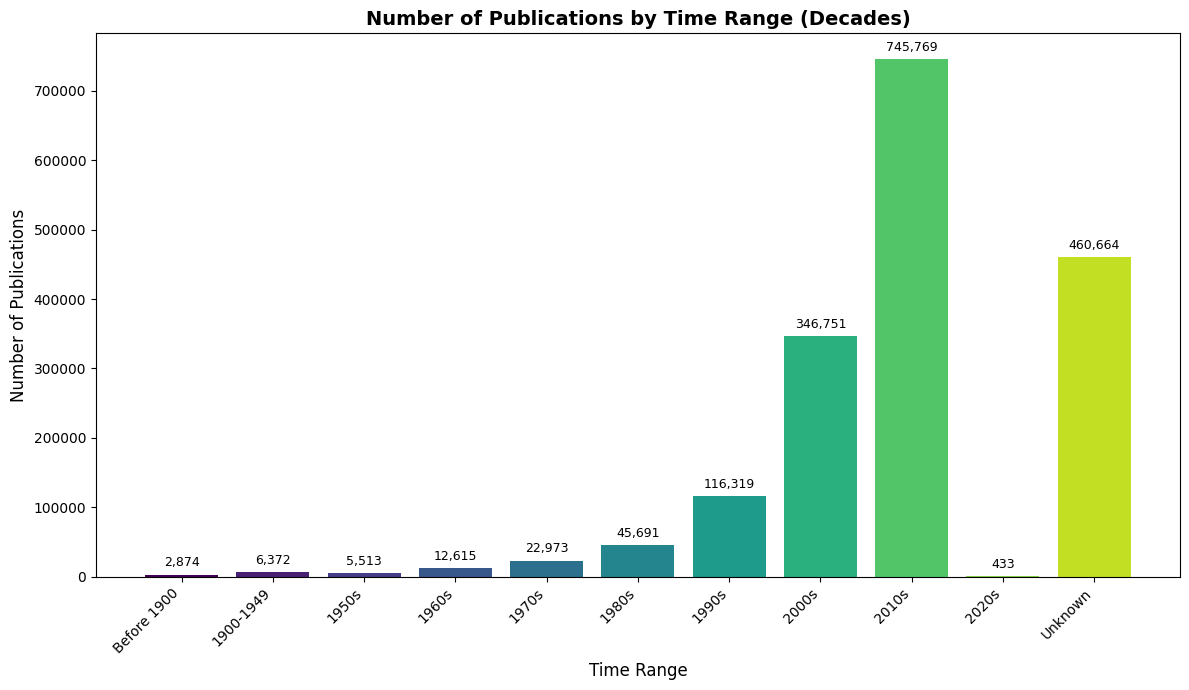

Chart saved as 'publications_by_time_range.png'

SUMMARY STATISTICS

Total Books: 1,765,974
Total Unique Publishers: 173,889
Publication Years Range: 1 - 2099

Analysis completed successfully!


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, trim, count, desc
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder \
    .appName("BooksAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

PARQUET_PATH = "goodreads_books_clean"
print("Loading cleaned books data...")
books_df = spark.read.parquet(PARQUET_PATH)

books_df.createOrReplaceTempView("books")

print("\n" + "="*60)
print("1. PUBLISHER DOMINANCE ANALYSIS")
print("="*60)

publisher_query = """
SELECT
    TRIM(publisher) AS publisher_name,
    COUNT(*) AS publication_count
FROM books
WHERE publisher IS NOT NULL AND TRIM(publisher) != ''
GROUP BY TRIM(publisher)
ORDER BY publication_count DESC
LIMIT 40
"""

publisher_df = spark.sql(publisher_query)
print("\nTop 40 Publishers by Number of Publications:")
publisher_df.show(40, truncate=False)

publisher_pd = publisher_df.toPandas()

plt.figure(figsize=(14, 12))
bars = plt.barh(publisher_pd['publisher_name'][::-1], publisher_pd['publication_count'][::-1], color='steelblue')
plt.xlabel('Number of Publications', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.title('Top 40 Publishers by Number of Publications', fontsize=14, fontweight='bold')
plt.tight_layout()

for bar, value in zip(bars, publisher_pd['publication_count'][::-1]):
    plt.text(value + max(publisher_pd['publication_count']) * 0.01, bar.get_y() + bar.get_height()/2,
             f'{value:,}', va='center', fontsize=9)

plt.savefig('publisher_dominance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved as 'publisher_dominance.png'")

print("\n" + "="*60)
print("2. PUBLICATIONS BY TIME RANGES (DECADES)")
print("="*60)

time_range_query = """
SELECT
    CASE
        WHEN TRY_CAST(publication_year AS INT) IS NULL THEN 'Unknown'
        WHEN TRY_CAST(publication_year AS INT) < 1900 THEN 'Before 1900'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1900 AND 1949 THEN '1900-1949'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1950 AND 1959 THEN '1950s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1960 AND 1969 THEN '1960s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1970 AND 1979 THEN '1970s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1980 AND 1989 THEN '1980s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1990 AND 1999 THEN '1990s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 2000 AND 2009 THEN '2000s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 2010 AND 2019 THEN '2010s'
        WHEN TRY_CAST(publication_year AS INT) >= 2020 THEN '2020s'
        ELSE 'Unknown'
    END AS time_range,
    COUNT(*) AS publication_count
FROM books
GROUP BY
    CASE
        WHEN TRY_CAST(publication_year AS INT) IS NULL THEN 'Unknown'
        WHEN TRY_CAST(publication_year AS INT) < 1900 THEN 'Before 1900'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1900 AND 1949 THEN '1900-1949'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1950 AND 1959 THEN '1950s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1960 AND 1969 THEN '1960s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1970 AND 1979 THEN '1970s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1980 AND 1989 THEN '1980s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 1990 AND 1999 THEN '1990s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 2000 AND 2009 THEN '2000s'
        WHEN TRY_CAST(publication_year AS INT) BETWEEN 2010 AND 2019 THEN '2010s'
        WHEN TRY_CAST(publication_year AS INT) >= 2020 THEN '2020s'
        ELSE 'Unknown'
    END
ORDER BY
    CASE time_range
        WHEN 'Before 1900' THEN 1
        WHEN '1900-1949' THEN 2
        WHEN '1950s' THEN 3
        WHEN '1960s' THEN 4
        WHEN '1970s' THEN 5
        WHEN '1980s' THEN 6
        WHEN '1990s' THEN 7
        WHEN '2000s' THEN 8
        WHEN '2010s' THEN 9
        WHEN '2020s' THEN 10
        ELSE 11
    END
"""

time_range_df = spark.sql(time_range_query)
print("\nPublications by Time Range:")
time_range_df.show(truncate=False)

time_range_pd = time_range_df.toPandas()

time_order = ['Before 1900', '1900-1949', '1950s', '1960s', '1970s',
              '1980s', '1990s', '2000s', '2010s', '2020s', 'Unknown']

time_range_pd['time_range'] = pd.Categorical(time_range_pd['time_range'],
                                              categories=time_order,
                                              ordered=True)
time_range_pd = time_range_pd.sort_values('time_range')

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis([i/len(time_range_pd) for i in range(len(time_range_pd))])
bars = plt.bar(time_range_pd['time_range'], time_range_pd['publication_count'], color=colors)
plt.xlabel('Time Range', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.title('Number of Publications by Time Range (Decades)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar, value in zip(bars, time_range_pd['publication_count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(time_range_pd['publication_count']) * 0.01,
             f'{value:,}', ha='center', va='bottom', fontsize=9, rotation=0)

plt.savefig('publications_by_time_range.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved as 'publications_by_time_range.png'")

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

total_books = books_df.count()
total_publishers = spark.sql("SELECT COUNT(DISTINCT publisher) FROM books WHERE publisher IS NOT NULL AND TRIM(publisher) != ''").collect()[0][0]
years_covered = spark.sql("""
    SELECT MIN(TRY_CAST(publication_year AS INT)) as min_year,
           MAX(TRY_CAST(publication_year AS INT)) as max_year
    FROM books
    WHERE publication_year IS NOT NULL
      AND TRY_CAST(publication_year AS INT) IS NOT NULL
      AND TRY_CAST(publication_year AS INT) > 0
      AND TRY_CAST(publication_year AS INT) < 2100
""").collect()[0]

print(f"\nTotal Books: {total_books:,}")
print(f"Total Unique Publishers: {total_publishers:,}")
print(f"Publication Years Range: {years_covered['min_year']} - {years_covered['max_year']}")

spark.stop()
print("\nAnalysis completed successfully!")


Task #3

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, when, lit, udf, length
from pyspark.sql.types import FloatType, ArrayType, StructType, StructField, StringType, DoubleType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.linalg import SparseVector, Vectors
import numpy as np

spark = SparkSession.builder \
    .appName("SimilarBooksFinder") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "20") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

PARQUET_PATH = "goodreads_books_clean"
SAMPLE_SIZE = 50000

print("Loading cleaned books data...")
books_df = spark.read.parquet(PARQUET_PATH)

print(f"Total books loaded: {books_df.count()}")

books_with_desc = books_df.filter(
    (col("description").isNotNull()) &
    (trim(col("description")) != "") &
    (length(col("description")) > 100)
).select("book_id", "title", "authors_clean", "description")

print(f"Books with substantial descriptions: {books_with_desc.count()}")

print(f"Sampling {SAMPLE_SIZE} books for TF-IDF analysis...")
books_sample = books_with_desc.orderBy(col("book_id")).limit(SAMPLE_SIZE)

books_sample = books_sample.withColumn(
    "description_clean",
    trim(col("description"))
)

tokenizer = Tokenizer(inputCol="description_clean", outputCol="words")

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=5000)

idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

print("Building TF-IDF model...")
model = pipeline.fit(books_sample)

print("Transforming book descriptions to TF-IDF vectors...")
tfidf_df = model.transform(books_sample)

tfidf_df = tfidf_df.select("book_id", "title", "authors_clean", "description", "tfidf_features")

print("Collecting TF-IDF data to driver for similarity computation...")
tfidf_data = tfidf_df.collect()
print(f"TF-IDF transformation complete. Processed {len(tfidf_data)} books.")

book_index = {row["book_id"]: i for i, row in enumerate(tfidf_data)}
title_index = {}
for i, row in enumerate(tfidf_data):
    title_lower = row["title"].lower() if row["title"] else ""
    if title_lower not in title_index:
        title_index[title_lower] = i

def cosine_similarity(v1, v2):
    if v1 is None or v2 is None:
        return 0.0

    if isinstance(v1, SparseVector) and isinstance(v2, SparseVector):
        indices1 = set(v1.indices)
        indices2 = set(v2.indices)
        common_indices = indices1.intersection(indices2)

        if not common_indices:
            return 0.0

        dot_product = sum(v1[int(i)] * v2[int(i)] for i in common_indices)
        norm1 = np.sqrt(sum(v1[int(i)] ** 2 for i in v1.indices))
        norm2 = np.sqrt(sum(v2[int(i)] ** 2 for i in v2.indices))

        if norm1 == 0 or norm2 == 0:
            return 0.0

        return float(dot_product / (norm1 * norm2))

    return 0.0

def find_similar_books(book_id, top_n=10):
    if book_id not in book_index:
        print(f"Book with ID {book_id} not found in sample.")
        return None

    target_idx = book_index[book_id]
    target_row = tfidf_data[target_idx]
    target_vector = target_row["tfidf_features"]
    target_title = target_row["title"]
    target_author = target_row["authors_clean"]

    print(f"\n{'='*60}")
    print(f"Finding similar books for:")
    print(f"Title: {target_title}")
    print(f"Author: {target_author}")
    print(f"{'='*60}")

    similarities = []
    for i, row in enumerate(tfidf_data):
        if i == target_idx:
            continue
        sim = cosine_similarity(target_vector, row["tfidf_features"])
        if sim > 0:
            similarities.append({
                "book_id": row["book_id"],
                "title": row["title"],
                "author": row["authors_clean"],
                "similarity": sim
            })

    similarities.sort(key=lambda x: x["similarity"], reverse=True)

    return similarities[:top_n]

def find_similar_books_by_title(title_search, top_n=10):
    title_search_lower = title_search.lower()
    matching_idx = None

    for i, row in enumerate(tfidf_data):
        if title_search_lower in row["title"].lower():
            matching_idx = i
            break

    if matching_idx is None:
        print(f"No books found matching '{title_search}'")
        return None

    return find_similar_books(tfidf_data[matching_idx]["book_id"], top_n)

def display_similar_books(similar_books, book_title):
    if not similar_books:
        return
    print(f"\n📚 Similar to '{book_title}':")
    for i, book in enumerate(similar_books[:5], 1):
        similarity_pct = book["similarity"] * 100
        title_display = book['title'][:45] if book['title'] else 'Unknown'
        print(f"  {i}. {title_display:<45} ({similarity_pct:.1f}%)")

print("\n" + "="*60)
print("SIMILAR BOOKS FINDER - TF-IDF Based Recommendation")
print("="*60)

example1 = find_similar_books_by_title("Pride and Prejudice", top_n=5)
if example1:
    display_similar_books(example1, "Pride and Prejudice")

example2 = find_similar_books_by_title("The Da Vinci Code", top_n=5)
if example2:
    display_similar_books(example2, "The Da Vinci Code")

spark.stop()
print("\nSimilar Books Finder completed successfully!")


Loading cleaned books data...
Total books loaded: 1765974
Books with substantial descriptions: 1370949
Sampling 50000 books for TF-IDF analysis...
Building TF-IDF model...
Transforming book descriptions to TF-IDF vectors...
TF-IDF transformation complete. Processed 50000 books.

SIMILAR BOOKS FINDER - TF-IDF Based Recommendation

Finding similar books for:
Title: Pride and Prejudice.
Author: 1265

📚 Similar to 'Pride and Prejudice':
  1. Trots en vooroordeel                          (100.0%)
  2. Arawn's Quest: The Zen Chronicles Book One    (15.4%)
  3. Stiff Upper Lip, Jeeves                       (15.0%)
  4. Horse and Buggy West: A Boyhood on the Fronti (14.6%)
  5. Pemberley: Or Pride and Prejudice Continued   (14.5%)

Finding similar books for:
Title: The Da Vinci Hoax: Exposing the Errors in the Da Vinci Code
Author: 61545, 61544, 710347, 233191

📚 Similar to 'The Da Vinci Code':
  1. The Da Vinci Notebooks: A Dazzling Array of d (26.2%)
  2. The Best Catholic Writing 2004      